In [1]:
from TimeTagger import FileReader
import numpy as np
import easygui
import numpy as np
import matplotlib.pyplot as plt

We know that H and V got swapped in BOB so I must correct for it in code. 

In [2]:
#GLOBAL DEFINITIONS
H = 1
V = 2
A = 3
D = 4


In [3]:
#folder = r'C:\Data\\'
folder = "./swabian/20200714_Swabian_Timestamp/data_2"
#file = '2.97mW_1.1.ttbin'
file = "4_1uW0dB.1.ttbin"
filepath = folder + '/' + file

#filepath = easygui.fileopenbox(default = folder)






In [4]:
def loadSwabianTimeStamps(fileIn, t = np.inf):
    
        file_reader = FileReader(fileIn)
        stamps = []
        channel = []
        
        
        while file_reader.hasData():
            #n_events = 100000; # Number of events to read at once
            n_events = 100000; # Number of events to read at once
            
            # Read at most n_events.
            data = file_reader.getData(n_events);  # data is an instance of TimeTagStreamBuffer

            channelTmp = data.getChannels()
            stampsTmp = data.getTimestamps()
          #  overflow_types = data.getEventTypes()   # TimeTag = 0, Error = 1, OverflowBegin = 2, OverflowEnd = 3, MissedEvents = 4
          #  missed_events = data.getMissedEvents()
            
            for i in range(len(channelTmp)):
                channel.append(channelTmp[i])
                stamps.append(stampsTmp[i])
            break
            if stamps[-1] - stamps[0] > t:
                break
        return stamps, channel


In [5]:
stamps, channel = loadSwabianTimeStamps(filepath)

In [6]:
channel[:20]

[2, 6, 2, 8, 1, 2, 4, 4, 5, 8, 5, 7, 3, 7, 4, 6, 5, 6, 1, 5]

In [7]:
#seperate out alice's and bob's events
astamps = []
achannel = []
bstamps = []
bchannel = []
for (s,c) in zip(stamps, channel):
    if (c <=4):
        astamps.append(s)
        achannel.append(c)
    else:
        bstamps.append(s)
        nc = c-4
        
        
        if (nc==3):
            nc = 4
        elif (nc == 4):
            nc = 3
        bchannel.append(nc)

In [8]:
len(astamps)

44939

In [9]:
len(bstamps)

55061

In [10]:
577447917

577447917

In [11]:
len(bstamps)+len(astamps)

100000

In [12]:
#convert the resolution to 1/8 of a nanosecond
#saverawevents

In [13]:
100*(astamps[-1] - astamps[0])/10**12

1.0086875374

In [14]:
achannel[-1]

1

In [15]:
astamps[:10]

[1086398751803,
 1086398894346,
 1086398985766,
 1086399116932,
 1086399157249,
 1086399262520,
 1086399490280,
 1086399689867,
 1086400241735,
 1086400301477]

In [16]:
achannel[:10]

[2, 2, 1, 2, 4, 4, 3, 4, 1, 2]

In [17]:
len(astamps)

44939

In [18]:
2197945792/64

34342903.0

In [19]:
def coincount(at,ad,bt,bd,amd=H,bmd=H,cwindow=1000,shift=0 ):
    #print("coincount: ",amd,bmd,cwindow,shift)
    ia = 0
    ib = 0
    coin_count = 0
    while (ia<len(at) and ib <len(bt)):
        #ignore beacon events
        if (ad[ia]!=amd):
            ia+=1
            continue
        if (bd[ib]!=bmd):
            ib+=1
            continue
            
        diff = bt[ib]- at[ia] + shift

        if (abs(diff)<=cwindow):
            coin_count +=1
            
            ia+=1
            ib+=1
            #continue
        elif (diff>cwindow):
            ia+=1
            #continue
        elif( diff <-cwindow):
            ib+=1
            #continue
        else:
            print ("ERROR! I should not be here")
            break
    return coin_count


In [20]:
#x = coincount(astamps, achannel,bstamps, bchannel, H, H,cwindow=1000,shift=0)
#x

In [21]:
def g2_heisto(at,ad,bt,bd,amd=H,bmd=H,cwindow=1000,search_steps=10,search_direction=1):
    heisto = []
    i = 0
    count = 0
    while(i<search_steps):
        shift = i*cwindow*search_direction
        count = coincount(at, ad,bt, bd, amd,bmd,cwindow=cwindow,shift=shift)
        #print (count)
        heisto.append(count)
        i += 1
    return heisto 

In [22]:
len(astamps)

44939

In [23]:
astamps[0]

1086398751803

[12, 14, 18, 13, 18, 28, 26, 23, 21, 31, 37, 26, 22, 19, 24, 25, 13, 13, 16, 19]
10


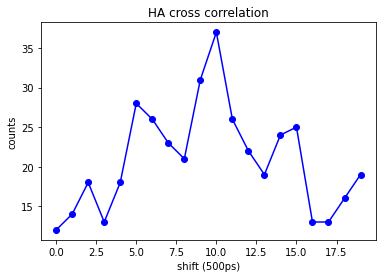

In [24]:
h = g2_heisto(astamps, achannel,bstamps, bchannel, amd=H ,bmd=V,cwindow=500,search_steps=20,search_direction=-1)
print (h)
print(h.index(max(h)))
plt.title('HA cross correlation')
plt.xlabel("shift (500ps)")
plt.ylabel("counts")
plt.plot(h,'-bo')

In [25]:
detectors = ["_","H","V","A","D"]

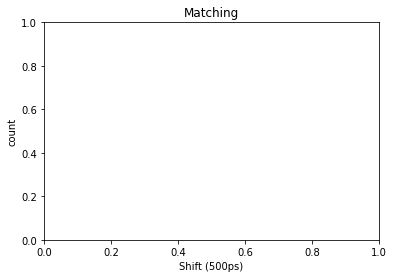

In [29]:
for i in range (1,5):
    for j in range (1,5):
        if(False):
            h = g2_heisto(astamps, achannel,bstamps, bchannel, amd=i, bmd=j,cwindow=500,search_steps=20,search_direction=-1)
            print ("detectors", detectors[i],detectors[j],"\tshiftsteps",h.index(max(h)),"\tcoincount",max(h))
            #if (i==j) 
            plt.plot(h, marker='o', label=detectors[i]+detectors[j])

plt.title("Matching")
plt.xlabel("Shift (500ps)")
plt.ylabel("count")
#plt.legend()
plt.savefig("./plots/Matching.jpg")
plt.show()

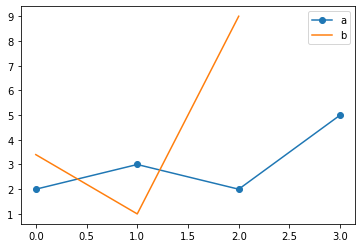

In [30]:
a = [2,3,2,5]
b = [3.4,1,9]

plt.plot(a,marker='o',label="a")
plt.plot(b,label='b')
plt.legend()
plt.show()

In [31]:
def correct_timestamp(stamps,detectors,sH=0,sV=0,sA=0,sD=0):
    cstamp=[]
    ts = 0
    for (s,d) in zip (stamps,detectors):
        ts = s
        if(d==H): 
            ts+=sH
        elif(d==V):
            ts+=sV
        elif(d==A):
            ts+=sA
        elif(d==D):
            ts+=sD      
        cstamp.append(ts)
    return cstamp

In [32]:
#correct alice HV delay missmatch add 500ps to alice's V 
astamps_corrected = correct_timestamp(astamps,achannel,sH=1*500,sV=3*500,sA=3*500,sD=0)

In [33]:
#h = g2_heisto(astamps_corrected, achannel,bstamps, bchannel, amd=H, bmd=H,cwindow=500,search_steps=30,search_direction=-1)
#print (h)
#h.index(max(h))

In [34]:
#correct Bob
# add 7 To Bob's A basis
bstamps_corrected = correct_timestamp(bstamps,bchannel,sH=5*500,sV=5*500,sA=0,sD=6*500)

[7, 8, 11, 9, 8, 8, 8, 7, 7, 6, 15, 55, 526, 745, 288, 39, 16, 16, 17, 8]
shift = 13


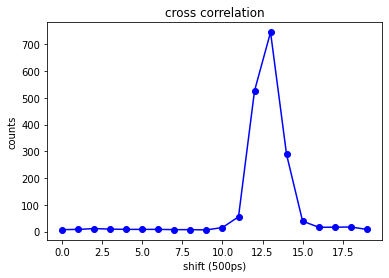

In [35]:
h = g2_heisto(astamps_corrected, achannel,bstamps_corrected, bchannel, amd=A ,bmd=A,cwindow=500,search_steps=20,search_direction=-1)
print (h)
print("shift =",h.index(max(h)))
plt.title('cross correlation')
plt.xlabel("shift (500ps)")
plt.ylabel("counts")
plt.plot(h,'-bo')


In [36]:
hh = {}

In [37]:
for i in range (1,5):
    for j in range (1,5):
        
        h = g2_heisto(astamps_corrected, achannel,bstamps_corrected, bchannel, amd=i, bmd=j,cwindow=500,search_steps=20,search_direction=-1)
        hh[str(i)+str(j)] = h
        
        print ("detectors", detectors[i],detectors[j],"\tshiftsteps",h.index(max(h)),"\tcoincount",max(h))

detectors H H 	shiftsteps 13 	coincount 1383
detectors H V 	shiftsteps 14 	coincount 37
detectors H A 	shiftsteps 14 	coincount 523
detectors H D 	shiftsteps 13 	coincount 875
detectors V H 	shiftsteps 12 	coincount 26
detectors V V 	shiftsteps 13 	coincount 1274
detectors V A 	shiftsteps 13 	coincount 673
detectors V D 	shiftsteps 13 	coincount 572
detectors A H 	shiftsteps 12 	coincount 373
detectors A V 	shiftsteps 13 	coincount 370
detectors A A 	shiftsteps 13 	coincount 745
detectors A D 	shiftsteps 13 	coincount 48
detectors D H 	shiftsteps 13 	coincount 329
detectors D V 	shiftsteps 13 	coincount 394
detectors D A 	shiftsteps 13 	coincount 25
detectors D D 	shiftsteps 13 	coincount 760


detectors D H 	shiftsteps 13 	coincount 1521
detectors D V 	shiftsteps 13 	coincount 1521
detectors D A 	shiftsteps 13 	coincount 1521
detectors D D 	shiftsteps 13 	coincount 1521


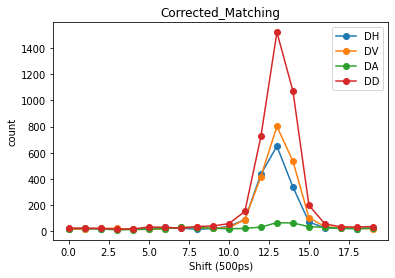

In [178]:
for i in range (1,5):
    for j in range (1,5):
        if(i==D):
            #h = g2_heisto(astamps, achannel,bstamps, bchannel, amd=i, bmd=j,cwindow=500,search_steps=20,search_direction=-1)
            print ("detectors", detectors[i],detectors[j],"\tshiftsteps",h.index(max(h)),"\tcoincount",max(h))
            #if (i==j) 
            plt.plot(hh[str(i)+str(j)], marker='o', label=detectors[i]+detectors[j])

plt.title("Corrected_Matching")
plt.xlabel("Shift (500ps)")
plt.ylabel("count")
plt.legend()
plt.savefig("./plots/Corrected_Matching.jpg")
plt.show()

In [34]:
h = g2_heisto(astamps_corrected, achannel,bstamps_corrected, bchannel, amd=D, bmd=D,cwindow=500,search_steps=20,search_direction=-1)
print (h)
h.index(max(h))

[22, 23, 18, 18, 28, 30, 30, 32, 35, 51, 104, 392, 1316, 1396, 450, 76, 40, 34, 33, 31]


13

In [36]:
print (hh[str(4)+str(4)])

[22, 23, 18, 18, 28, 30, 30, 32, 35, 51, 104, 392, 1316, 1396, 450, 76, 40, 34, 33, 31]


In [38]:
def match_coincidence(at,ad,bt,bd,cwindow,shift):
    ia = 0
    ib = 0
    acoin_indexes = []
    bcoin_indexes = []
    while (ia<len(at) and ib <len(bt)):
        
        diff = bt[ib]- at[ia] + shift

        if (abs(diff)<=cwindow):
            #coin_count +=1
            acoin_indexes.append(ia)
            bcoin_indexes.append(ib)
            ia+=1
            ib+=1
            #continue
        elif (diff>cwindow):
            ia+=1
            #continue
        elif( diff <-cwindow):
            ib+=1
            #continue
        else:
            print ("ERROR! I should not be here")
            break
    return acoin_indexes,bcoin_indexes
    

In [39]:
ac_indexes,bc_indexes = match_coincidence(astamps_corrected,achannel,bstamps_corrected,bchannel,1500,-13*500)

In [40]:
len(ac_indexes)

10063

In [41]:
len(ac_indexes)/ len(astamps)

0.2239257660384076

In [42]:
ac_indexes[:10]

[1, 5, 8, 9, 11, 20, 21, 22, 23, 24]

In [43]:
bc_indexes[:10]

[1, 2, 10, 11, 12, 24, 25, 26, 30, 32]

In [44]:
print(astamps_corrected[51],bstamps_corrected[76], bstamps_corrected[76] - astamps_corrected[51]-9*500)

1086407877284 1086410543788 2662004


In [45]:
basis_count = 0
error_count = 0
for (a,b) in zip(ac_indexes,bc_indexes):
    da = achannel[a]
    db = bchannel[b]
    if (da >= 3 and db >= 3):
        #basis HV
        #print(da,db)
        basis_count+=1
        if (da!=db):
            error_count+=1
    if( da<3 and db <3):
        #print (da,db)
        if(da!=db):
            error_count+=1
        basis_count+=1

In [46]:
basis_count

5044

In [47]:
error_count

228

In [48]:
QBER = error_count / basis_count
QBER*100

4.520222045995242

In [49]:
astamps_corrected[0:10]

[1086398753303,
 1086398895846,
 1086398986266,
 1086399118432,
 1086399157249,
 1086399262520,
 1086399491780,
 1086399689867,
 1086400242235,
 1086400302977]

In [50]:
bstamps_corrected[0:10]

[1086398878055,
 1086398902493,
 1086399268952,
 1086399304476,
 1086399339497,
 1086399344556,
 1086399650658,
 1086399828964,
 1086400123960,
 1086400192146]

In [54]:
len (ac_indexes) / len(astamps_corrected)

0.2239257660384076

In [52]:
duration = astamps[-1]-astamps[0]
duration / (10**12)

0.010086875374

In [53]:
len(astamps)/10

4493.9

Singles rate 3.4 Million/s
coincidence rate 333 K/s 
QBER = 3.7 %
coincidence window 500 ps

for coincidence window of 1 ns QBER is around 4.2 %
